In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys

yolo_dir = Path.home()/'yolov5'
if yolo_dir.is_dir():
    sys.path.append(str(yolo_dir))

from utils.tools.general import *
from utils.tools.type_checker import is_2d_img, is_color_img, is_grey_img, is_bool_mask
from utils.tools.datasets import MaskedImage
from utils.tools.image import read_color_img
from IPython.display import display
from tqdm.notebook import tqdm
import imageio
import boxx
import utils.tools.image as iu


In [2]:

def format_disk(device_name):
    !sudo mkfs.ext4 -m 0 -E lazy_itable_init=0,lazy_journal_init=0,discard /dev/{device_name}

def mount_disk(device_name, mount_dir):
    !sudo mkdir -p /mnt/disks/{mount_dir}
    !sudo mount -o discard,defaults /dev/{device_name} /mnt/disks/{mount_dir}
    !sudo chmod a+w /mnt/disks/{mount_dir}

# mount_disk('sdb', 'lightbox_hand_eccsd-copy')
mount_disk('sdd', 'lightbox_hand_eccsd-copy')
!sudo lsblk 

NAME    MAJ:MIN RM   SIZE RO TYPE MOUNTPOINT
loop0     7:0    0  55.5M  1 loop /snap/core18/2246
loop1     7:1    0  55.5M  1 loop /snap/core18/2253
loop2     7:2    0  61.9M  1 loop /snap/core20/1169
loop3     7:3    0 251.7M  1 loop /snap/google-cloud-sdk/207
loop4     7:4    0  61.9M  1 loop /snap/core20/1242
loop5     7:5    0  67.2M  1 loop /snap/lxd/21835
loop6     7:6    0 251.7M  1 loop /snap/google-cloud-sdk/206
loop7     7:7    0  67.2M  1 loop /snap/lxd/21803
loop8     7:8    0  42.2M  1 loop /snap/snapd/13831
loop9     7:9    0  32.5M  1 loop /snap/snapd/13640
sda       8:0    0    20G  0 disk 
├─sda1    8:1    0  19.9G  0 part /
├─sda14   8:14   0     4M  0 part 
└─sda15   8:15   0   106M  0 part /boot/efi
sdb       8:16   0    10G  0 disk 
sdc       8:32   0    10G  0 disk 
sdd       8:48   0    10G  0 disk /mnt/disks/lightbox_hand_eccsd-copy
sde       8:64   0    30G  0 disk 
sdf       8:80   0    30G  0 disk 


In [3]:
back_img_dpath = yolo_dir/'datasets/coco128/images/train2017'
bimg_paths = pd.Series(back_img_dpath.ls('*.jpg'))

front_img_dpath = Path('/mnt/disks/lightbox_hand_eccsd-copy')

# load img and mask

In [6]:
%load_ext autoreload
%autoreload 2

from utils.paster.load_coco import Coco2Df
from utils.paster.load_datasets import LoadProduct, LoadNoise

lb_coco = Coco2Df(front_img_dpath/'lightbox_china_train'/'clean_coco.json')
eccsd_coco = Coco2Df(front_img_dpath/'eccsd'/'clean_coco.json')
hand_coco = Coco2Df(front_img_dpath/'cropped_hand_14k'/'clean_coco.json')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.29s)
creating index...
index created!


## load lightbox

In [7]:
corrupted_imgs = ['lightbox_china_train/images/h45__wangwang_coco_orange/0000028.jpg',
                    'lightbox_china_train/images/h45__wangwang_coco_orange/0000029.jpg',
                    'lightbox_china_train/images/h45__wangwang_coco_orange/0000030.jpg']

lb_coco = LoadProduct(front_img_dpath/'lightbox_china_train'/'clean_coco.json', front_img_dpath)
lb_coco.filter_front_img(corrupted_imgs)


loading annotations into memory...
Done (t=0.27s)
creating index...
index created!


bbox:  [833, 339, 1352, 673]


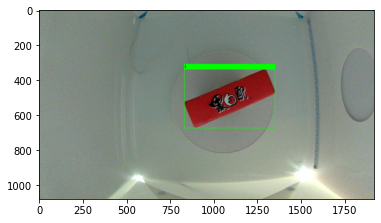

bbox:  [931, 425, 1088, 771]


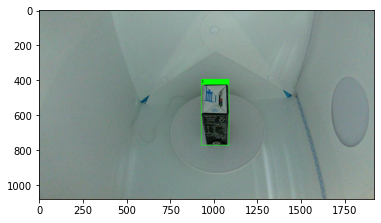

bbox:  [976, 322, 1227, 993]


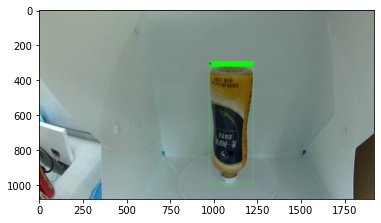

In [8]:

file_names, imgs, masks, cls_ids = lb_coco.next_batch(3)

for img, mask, cls_id in zip(imgs, masks, cls_ids):
    bbox = iu.bbox_from_mask(mask)
    print(f"bbox:  {bbox}")
    boxx.show(iu.draw_bb(img, [[cls_id, *bbox]], has_cls_id=True))


## load eccsd

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
bbox:  [119, 56, 217, 240]


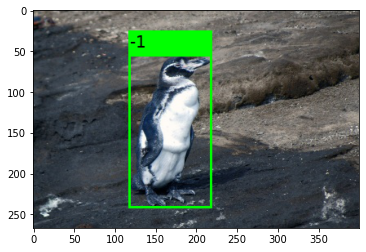

bbox:  [0, 113, 213, 331]


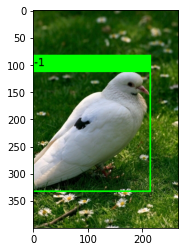

bbox:  [75, 84, 400, 266]


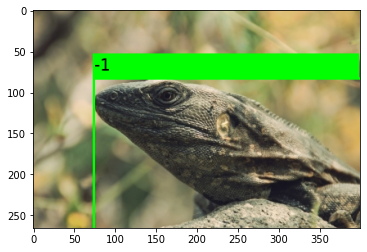

In [9]:
eccsd_coco = LoadNoise(front_img_dpath/'eccsd'/'clean_coco.json', front_img_dpath)

file_names, imgs, masks, cls_ids = eccsd_coco.next_batch(3)

for img, mask, cls_id in zip(imgs, masks, cls_ids):
    bbox = iu.bbox_from_mask(mask)
    print(f"bbox:  {bbox}")
    boxx.show(iu.draw_bb(img, [[cls_id, *bbox]], has_cls_id=True))


## hand 14k

loading annotations into memory...
Done (t=0.28s)
creating index...
index created!
bbox:  [0, 0, 188, 120]


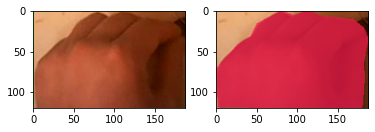

bbox:  [0, 0, 469, 307]


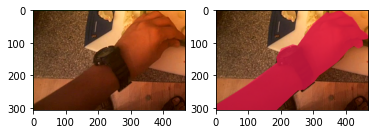

bbox:  [0, 0, 200, 99]


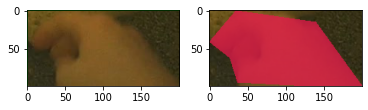

In [10]:
hand_coco = LoadNoise(front_img_dpath/'cropped_hand_14k'/'clean_coco.json', front_img_dpath)

file_names, imgs, masks, cls_ids = hand_coco.next_batch(3)

for img, mask, cls_id in zip(imgs, masks, cls_ids):
    bbox = iu.bbox_from_mask(mask)
    print(f"bbox:  {bbox}")
    boxx.show(
        iu.draw_bb(img, [[cls_id, *bbox]], has_cls_id=True),
        iu.draw_mask(img, mask)
    )




# augment

In [9]:
import imgaug.random as iarandom
import imgaug.augmenters as iaa

rng = iarandom.RNG(1234)

def transform(aug_sequence: List[iaa.Sequential], img, mask, rng_seed=None):
    segmap = iu.get_segmap(img, mask)
    aug_img, aug_segmap = iaa.Sequential(aug_sequence, seed=rng_seed)(image=img, segmentation_maps=segmap)
    return aug_img, aug_segmap.get_arr()

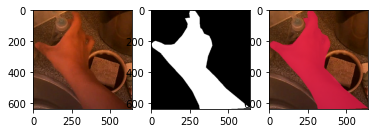

In [10]:
test_aug_seq = [iaa.Resize([640, 480])]

aug_img, aug_mask = transform(test_aug_seq, img, mask, rng)
boxx.show(aug_img, aug_mask, iu.draw_mask(aug_img, aug_mask))

# todo:
- set weighted df
- crop_before_aug?

In [11]:
from utils.paster.create_datasets import LoadProductWithNoise

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!
 angles list: ['tb45' 't45' 't90' 'hb45' 'tb90' 'h45']
loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


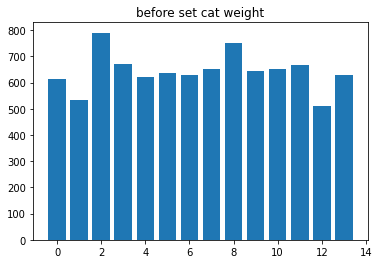

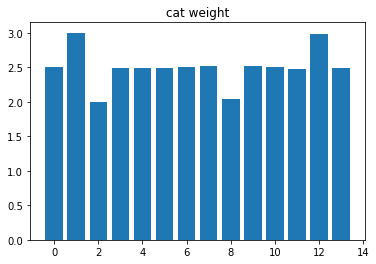

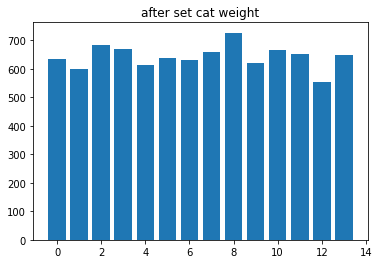

In [12]:
loader = LoadProductWithNoise()

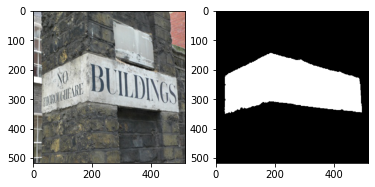

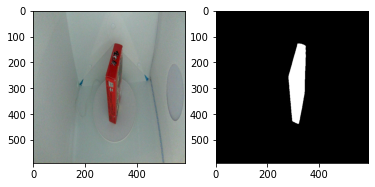

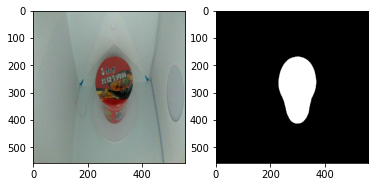

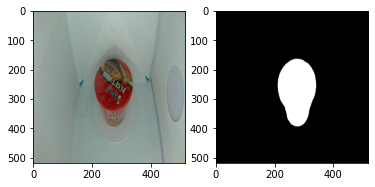

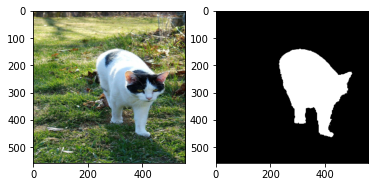

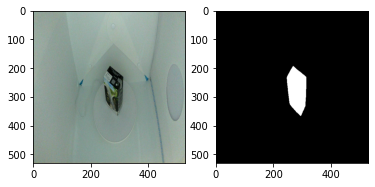

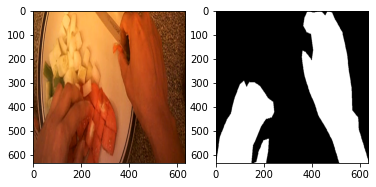

[None, None, None, None, None, None, None]

In [13]:
[mask_img.show_both() for mask_img in loader.next_batch_with_multiple_dataset(bs=7)]

# Stress test

In [14]:
def test_next_batch():
    return [mask_img for mask_img in loader.next_batch_with_multiple_dataset()]
    

In [15]:
def skip_non_color_img_in_loop(fn, n, *args, **kwargs):
    for i in tqdm(range(n)):
        try:
            fn(*args, **kwargs)
        except ValueError as e:
            if 'Only color img allowed' in e.args:
                print('skip non color img')
                continue
            else:
                raise e


skip_non_color_img_in_loop(test_next_batch, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
# '''try in terminal'''
# free -m -s2